In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from statsmodels.distributions.empirical_distribution import ECDF
from multifidelity.dl import MFDistributionLearning
from utils.utils import cdf_inverse

## Load data

In [22]:
df1 = pd.read_csv('./data/exploration_output.csv').loc[1:].to_numpy()[:,1:]
df2 = pd.read_csv('./data/exploitation_output.csv').loc[1:].to_numpy()[:,1:]
df_full_fixed = np.vstack((df1, df2))/1e6

## Simulation

In [23]:
import os
import random as random

## results holder
# cvMDL
cvMDL_l2 = [] # overall L^2 error
cvMDL_var = [] # 0.99-VaR   
cvMDL_cvar = [] # 0.99-CVaR
cvMDL_cvar2 = [] # 0.95-CVaR
cvMDL_mean = [] # mean
cvMDL_sd = [] # standard deviation

# ecdf
ecdf_l2 = []
ecdf_var = []
ecdf_cvar = []
ecdf_cvar2 = []
ecdf_mean = []
ecdf_sd = []

# oracle
oracle_var = []
oracle_cvar = []
oracle_cvar2 = []
oracle_mean = []
oracle_sd = []


# cvMDL input parameters
cost = [9.1,1.3,1.1,1,108.9]
tol_size = 4
budget = 20*1e3
# total number of simulations
N = 200
# maximum number of exploration samples
m = int(budget/cost[-1])
# random seed list
random.seed(321)
randseed = random.sample(range(10000), N)

foldername = f'result_{budget}'
if not os.path.exists(foldername):
    os.makedirs(foldername)
else:
    print("Folder already exists.")
    
# VaR/CVaR and moment parameters
alpha = 0.99
alpha2 = 0.95
# interval for CVaR computation
I = np.linspace(alpha,1-1e-8,5000)
# interval for moment statistics
I2 = np.linspace(alpha2,1-1e-8,5000)
# interval for moment statistics
II = np.linspace(1e-8,1-1e-8,5000)
# interval for overall error estimation
III = np.linspace(1.9,2.8,5000)
cvMDL_exp = 0

for i in range(N):
    print('i =', i)
    # randomly divide data into exploration and exploitation
    np.random.seed(randseed[i])
    S = np.random.permutation(df_full_fixed.shape[0])
    df_full = df_full_fixed[S,:]
    df_low = {i+1: df_full[:,i:(i+1)][:m,:] for i in range(4)}
    df_high = df_full[:,4:5][:m,:]
    df_tt = {i+1: df_full[:,i:(i+1)][m:,:] for i in range(4)}
    
    # compute oracle CDF (no more randomseed is needed here)
    y_oracle = ECDF(df_full[:,-1][m:]) 
    y_oracle_inv = cdf_inverse(y_oracle, interpolation = True, interval = [min(df_full[:,-1][m:]), max(df_full[:,-1][m:])])
    
    # cvMDL exploration
    a = MFDistributionLearning()
    cvMDL_res = a.cvMDL(df_low, df_high, cost, tol_size, budget)
    print('cvMDL: {}'.format({key: value for key, value in cvMDL_res.items() if key in ['model','exp_rate', 'sample_rate']}))
    cvMDL_exp = cvMDL_exp + cvMDL_res['exp_rate']
    
    # naive ecdf using high-fidelity samples only
    ecdf = ECDF(df_high.flatten()[:int(budget/cost[-1])])
    ecdf_inv = cdf_inverse(ecdf, interpolation = True, interval = [min(df_high.flatten()[:int(budget/cost[-1])]),\
                                                                   max(df_high.flatten()[:int(budget/cost[-1])])])
    
    # cvMDL exploitation
    cvMDL_exploit = a.ecdf_cv_1d(df_tt, cvMDL_res, inverse = True)
    cvMDL_cdf = cvMDL_exploit['cdf']
    cvMDL_cdf_inv = cvMDL_exploit['quantile']
    
    # compute mean errors
    cvMDL_l2.append(np.sum((y_oracle(III)-np.array([cvMDL_cdf(x) for x in III]))**2)*(III[1]-III[0]))
    ecdf_l2.append(np.sum((y_oracle(III)-ecdf(III))**2)*(III[1]-III[0]))
    print('L2 error: {}'.format({key: value for key, value in zip(['cvMLD', 'ecdf'], [cvMDL_l2[-1], ecdf_l2[-1]])}))
    
    # compute VaR/CVaR
    oracle_var.append(y_oracle_inv(alpha))
    cvMDL_var.append(cvMDL_cdf_inv(alpha))
    ecdf_var.append(ecdf_inv(alpha))
    print('VaR: {}'.format({key: value for key, value in zip(['oracle','cvMLD', 'ecdf'], [oracle_var[-1], cvMDL_var[-1], ecdf_var[-1]])}))
    
    oracle_cvar.append(np.sum(np.array([y_oracle_inv(x) for x in I])*(I[1]-I[0]))/(1-alpha))
    cvMDL_cvar.append(np.sum(np.array([cvMDL_cdf_inv(x) for x in I])*(I[1]-I[0]))/(1-alpha))
    ecdf_cvar.append(np.sum(np.array([ecdf_inv(x) for x in I])*(I[1]-I[0]))/(1-alpha))
    print('CVaR: {}'.format({key: value for key, value in zip(['oracle','cvMLD', 'ecdf'], [oracle_cvar[-1],cvMDL_cvar[-1], ecdf_cvar[-1]])}))
    
    oracle_cvar2.append(np.sum(np.array([y_oracle_inv(x) for x in I2])*(I2[1]-I2[0]))/(1-alpha2))
    cvMDL_cvar2.append(np.sum(np.array([cvMDL_cdf_inv(x) for x in I2])*(I2[1]-I2[0]))/(1-alpha2))
    ecdf_cvar2.append(np.sum(np.array([ecdf_inv(x) for x in I2])*(I2[1]-I2[0]))/(1-alpha2))
    print('CVaR2: {}'.format({key: value for key, value in zip(['oracle','cvMLD', 'ecdf'], [oracle_cvar2[-1],cvMDL_cvar2[-1], ecdf_cvar2[-1]])}))
    
    # compute moment statistics
    # inverse sampling
    oracle_dt = df_full[:,-1][m:]
    cvMDL_dt = np.array([cvMDL_cdf_inv(x) for x in II])
    ecdf_dt = df_high.flatten()[:int(budget/cost[-1])]
    # mean
    oracle_mean.append(np.mean(oracle_dt))
    cvMDL_mean.append(np.mean(cvMDL_dt))
    ecdf_mean.append(np.mean(ecdf_dt))
    print('mean: {}'.format({key: value for key, value in zip(['oracle','cvMLD', 'ecdf'], [oracle_mean[-1],cvMDL_mean[-1], ecdf_mean[-1]])}))
    # standard deviation
    oracle_sd.append(np.std(oracle_dt))
    cvMDL_sd.append(np.std(cvMDL_dt))
    ecdf_sd.append(np.std(ecdf_dt))
    print('std: {}'.format({key: value for key, value in zip(['oracle','cvMLD', 'ecdf'], [oracle_sd[-1],cvMDL_sd[-1], ecdf_sd[-1]])}))
    print('-------------------------------------------------------------------------------------------------------------')
    print('-------------------------------------------------------------------------------------------------------------')

i = 0
cvMDL: {'exp_rate': 142, 'model': [2, 4], 'sample_rate': 1200}
L2 error: {'cvMLD': 0.00012917063519458395, 'ecdf': 0.00034523317707753077}
VaR: {'oracle': array(2.65171344), 'cvMLD': array(2.65257024), 'ecdf': array(2.64354869)}
CVaR: {'oracle': 2.6832404247488046, 'cvMLD': 2.6645310561711897, 'ecdf': 2.6496269287927565}
CVaR2: {'oracle': 2.6218003616583028, 'cvMLD': 2.6142536811203514, 'ecdf': 2.6122599304012226}
mean: {'oracle': 2.3485626128018287, 'cvMLD': 2.349913632688572, 'ecdf': 2.3497977640894536}
std: {'oracle': 0.13340316387117848, 'cvMLD': 0.1350342146280519, 'ecdf': 0.14251413950773956}
-------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------
i = 1
cvMDL: {'exp_rate': 140, 'model': [2, 4], 'sample_rate': 1306}
L2 error: {'cvMLD': 0.00012601719558794043, 'ecdf': 0.00012171540801745906}
VaR: {'oracle': array(2

## Get average exploration rate

In [24]:
print('Average exploration rate:', cvMDL_exp/N)

Average exploration rate: 140.305


## Get average errors

In [25]:
cvMDL_cvar_error = abs(np.array(cvMDL_cvar)-np.array(oracle_cvar))
ecdf_cvar_error = abs(np.array(ecdf_cvar)-np.array(oracle_cvar))
cvMDL_cvar2_error = abs(np.array(cvMDL_cvar2)-np.array(oracle_cvar2))
ecdf_cvar2_error = abs(np.array(ecdf_cvar2)-np.array(oracle_cvar2))
cvMDL_mean_error = abs(np.array(cvMDL_mean)-np.array(oracle_mean))
ecdf_mean_error = abs(np.array(ecdf_mean)-np.array(oracle_mean))
cvMDL_sd_error = abs(np.array(cvMDL_sd)-np.array(oracle_sd))
ecdf_sd_error = abs(np.array(ecdf_sd)-np.array(oracle_sd))
print('L2 error: {}'.format({key: value for key, value in zip(['cvMLD', 'ecdf'], [np.mean(cvMDL_l2), np.mean(ecdf_l2)])}))
print('CVaR error: {}'.format({key: value for key, value in zip(['cvMLD', 'ecdf'], [np.mean(cvMDL_cvar_error), np.mean(ecdf_cvar_error)])}))
print('CVaR2 error: {}'.format({key: value for key, value in zip(['cvMLD', 'ecdf'], [np.mean(cvMDL_cvar2_error), np.mean(ecdf_cvar2_error)])}))                                                   
print('Mean error: {}'.format({key: value for key, value in zip(['cvMLD', 'ecdf'], [np.mean(cvMDL_mean_error), np.mean(ecdf_mean_error)])}))                                                                                  
print('Standard deviation error: {}'.format({key: value for key, value in zip(['cvMLD', 'ecdf'], [np.mean(cvMDL_sd_error), np.mean(ecdf_sd_error)])}))                                                                                  
                                                                                  

L2 error: {'cvMLD': 0.0002117363344148513, 'ecdf': 0.0004392823433453193}
CVaR error: {'cvMLD': 0.019408980478404364, 'ecdf': 0.0259309747051545}
CVaR2 error: {'cvMLD': 0.012049237075289432, 'ecdf': 0.018549551933122462}
Mean error: {'cvMLD': 0.0034146780931623177, 'ecdf': 0.007679946446578507}
Standard deviation error: {'cvMLD': 0.003070979868497617, 'ecdf': 0.006137096258002638}


## Demonstration of the last instance of cvMLD and ECDF

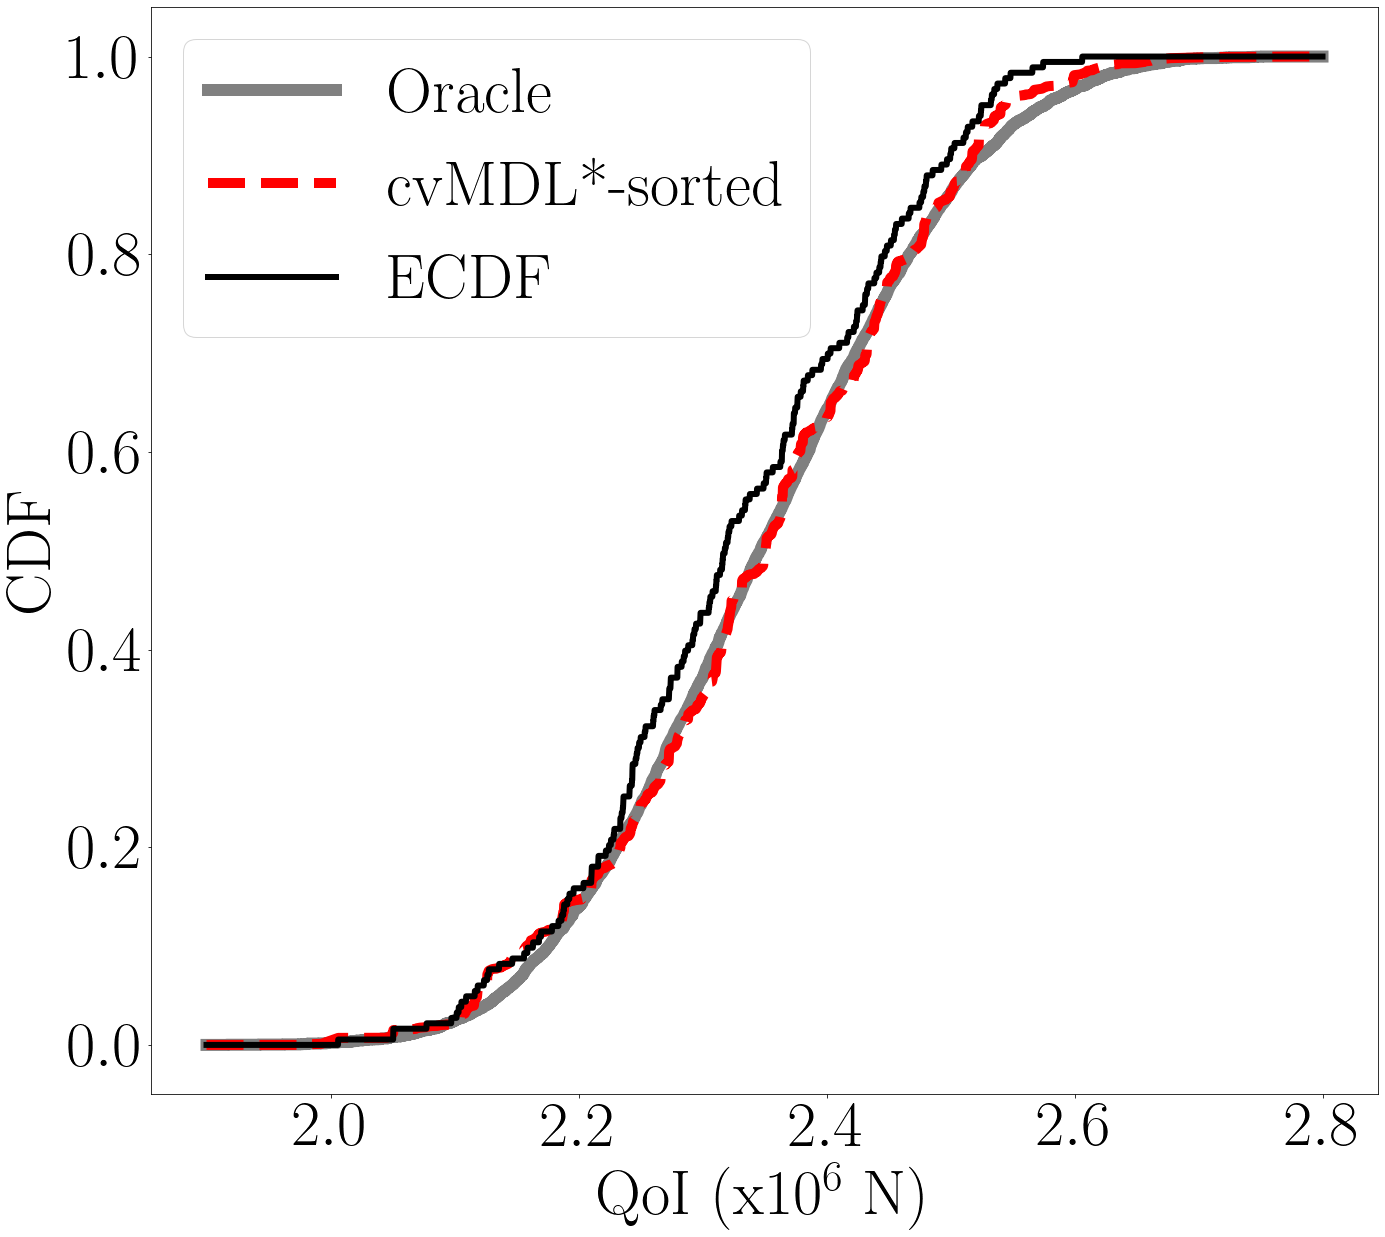

In [26]:
plt.figure(figsize=(22, 10*(24/12)))
plt.plot(III, y_oracle(III), linewidth= 12, color = 'gray', label = 'Oracle')
plt.plot(III, [cvMDL_exploit['cdf'](x) for x in III], linewidth = 10, color = 'red',  linestyle='--',label = 'cvMDL*-sorted')
plt.plot(III, ecdf(III), linewidth = 6, color = 'black', label = 'ECDF')

# Enable LaTeX rendering
rc('text', usetex=True)
# Set the desired font family
rc('font', family='serif')

plt.xlabel('QoI (x$10^6$ N)', size = 32*2.0)
plt.ylabel('CDF', size = 32*2.0)
plt.xticks(size = 32*2.0)
plt.yticks(size = 32*2.0)
plt.legend(fontsize = 32*2.0)

if not os.path.exists(foldername):
    os.makedirs(foldername)
plt.savefig(f"./{foldername}/brittle_cdf.pdf", dpi=600)

## Boxplot of CVaR

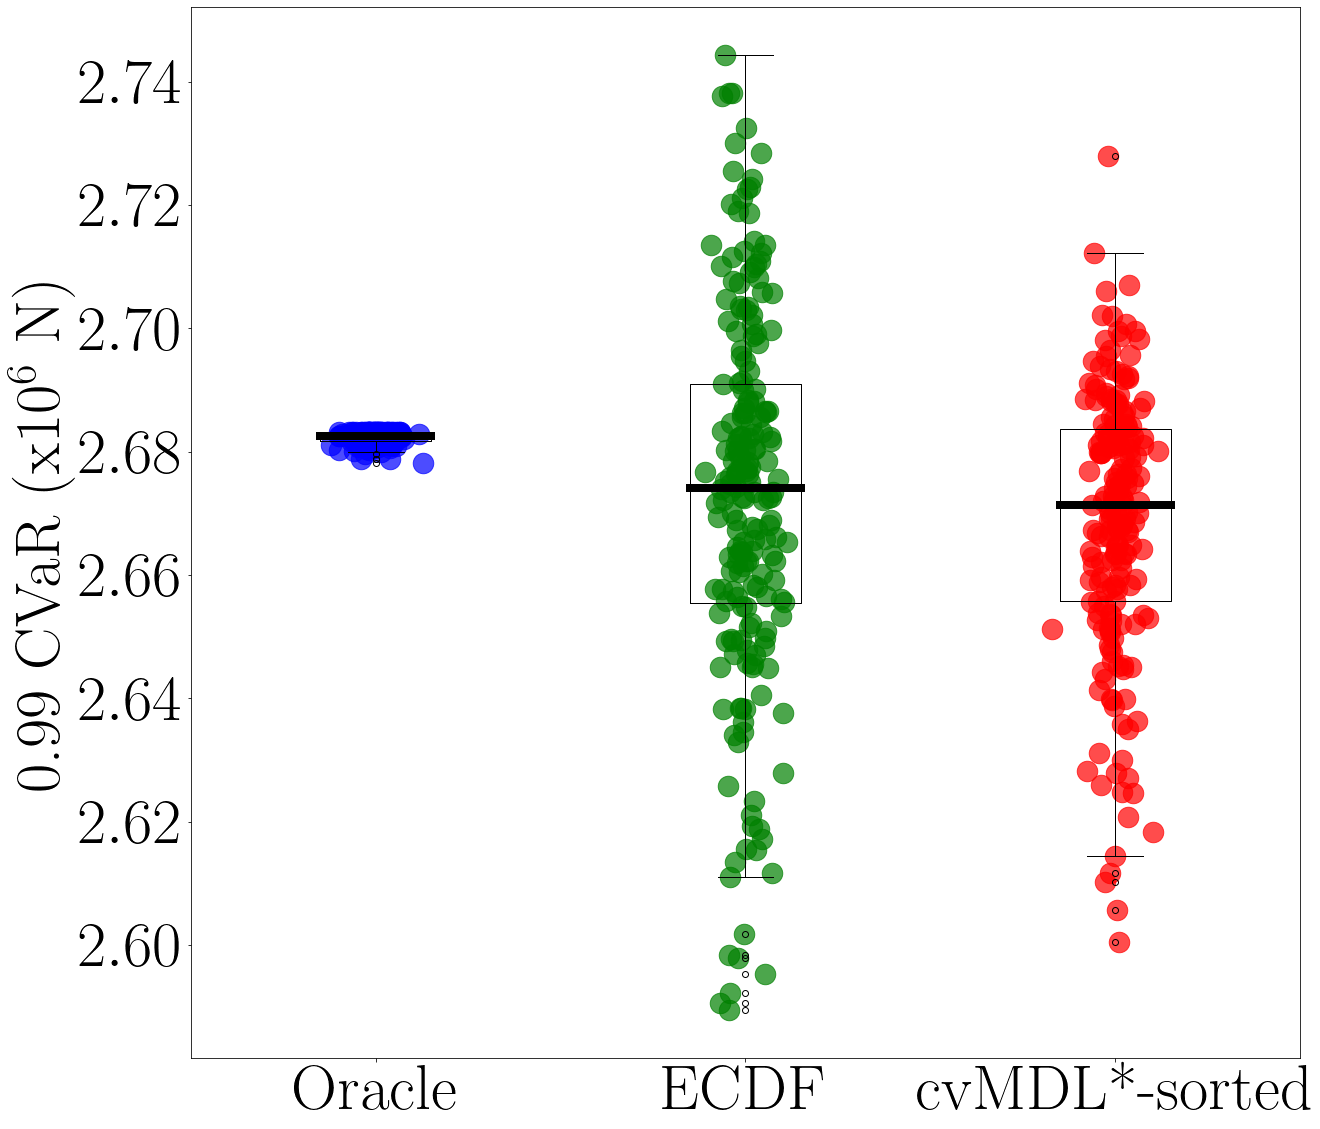

In [27]:
if not os.path.exists(foldername):
    os.makedirs(foldername)

data = [oracle_cvar, ecdf_cvar, cvMDL_cvar]

# ax.axhline(y=oracle_cvar[0],linestyle =':' ,color='black', label = 'Oracle')
#ax.set_ylim(2.58,2.68)
fig, ax = plt.subplots(figsize=(22, 10*(24/12)))
box = ax.boxplot(data, patch_artist=False, medianprops=dict(color='black', linewidth=2*4))
plt.xticks(size = 32*2.0)
plt.yticks(size = 32*2.0)

# Enable LaTeX rendering
rc('text', usetex=True)
# Set the desired font family
rc('font', family='serif')

ax.set_ylabel('0.99 CVaR (x$10^6$ N)', fontsize=32*2.0) # Add y-axis label
# Adding x-tick labels
xticklabels = ['Oracle', 'ECDF', 'cvMDL*-sorted']
yticklabels = ['Oracle', 'ECDF', 'cvMDL*-sorted']
ax.set_xticklabels(xticklabels)
colors = ['blue', 'green', 'red']
for i, datat in enumerate(data):
    x = np.random.normal(i + 1, 0.04, size=len(datat))
    ax.scatter(x, datat, color = colors[i], alpha=0.7, s = 420)
plt.subplots_adjust(left=0.2, bottom=0.15)
plt.savefig(f"./{foldername}/brittle_cvar0.99.pdf", dpi=600)

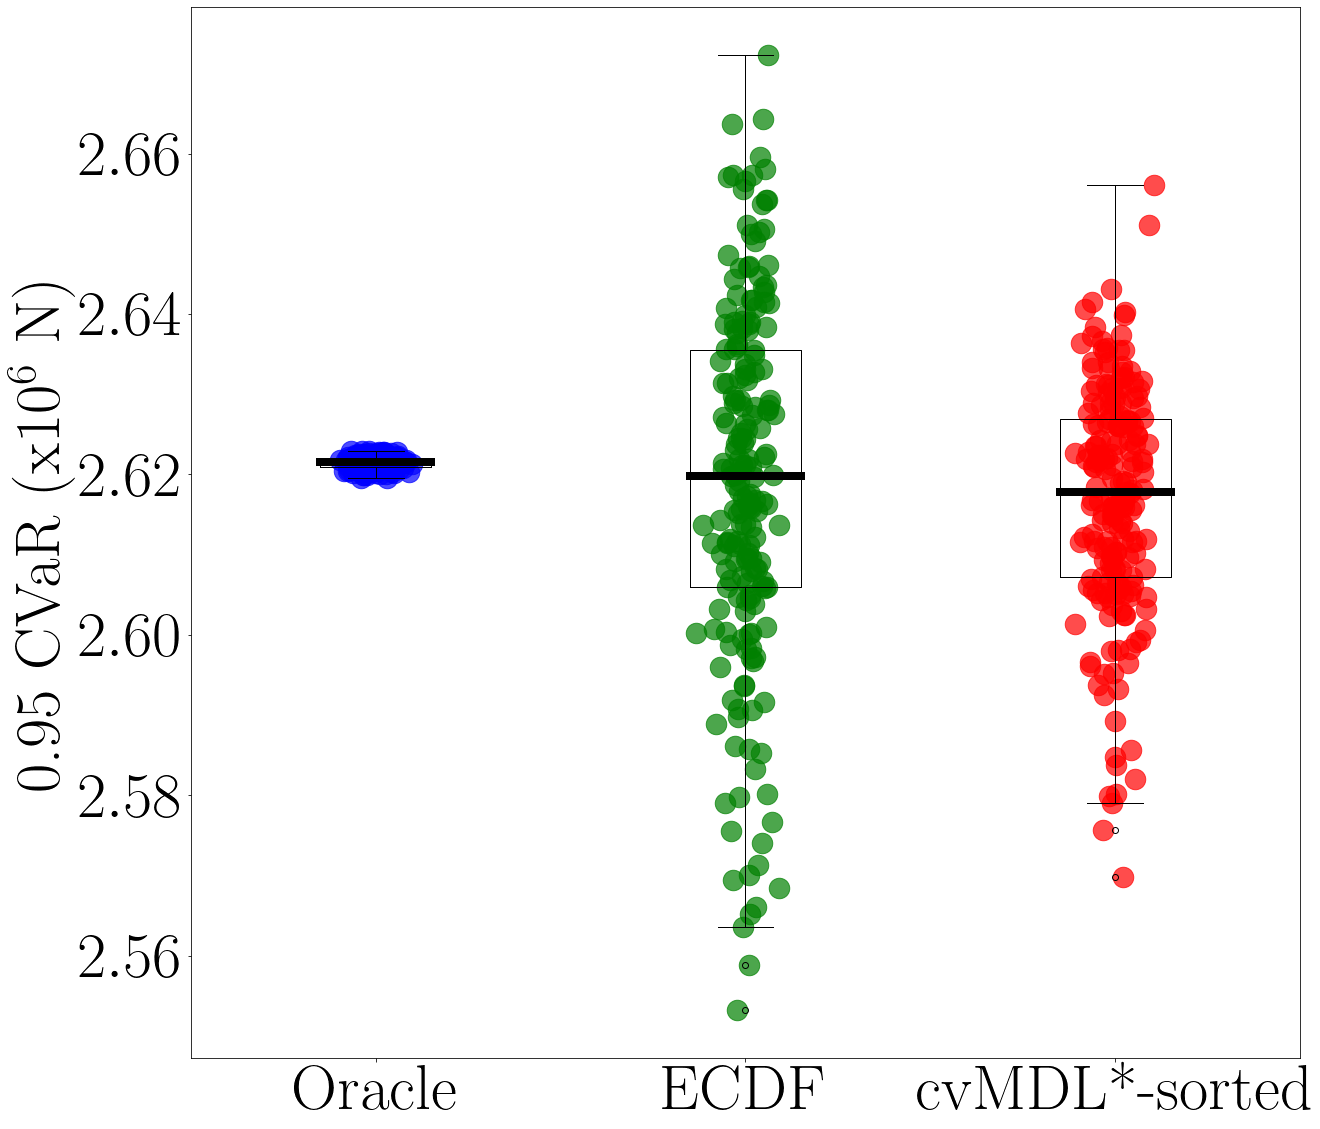

In [28]:
if not os.path.exists(foldername):
    os.makedirs(foldername)

data = [oracle_cvar2, ecdf_cvar2, cvMDL_cvar2]

# ax.axhline(y=oracle_cvar[0],linestyle =':' ,color='black', label = 'Oracle')
#ax.set_ylim(2.58,2.68)
fig, ax = plt.subplots(figsize=(22, 10*(24/12)))
box = ax.boxplot(data, patch_artist=False, medianprops=dict(color='black', linewidth=2*4))
plt.xticks(size = 32*2.0)
plt.yticks(size = 32*2.0)

# Enable LaTeX rendering
rc('text', usetex=True)
# Set the desired font family
rc('font', family='serif')


ax.set_ylabel('0.95 CVaR (x$10^6$ N)', fontsize=32*2.0) # Add y-axis label
# Adding x-tick labels
xticklabels = ['Oracle', 'ECDF', 'cvMDL*-sorted']
yticklabels = ['Oracle', 'ECDF', 'cvMDL*-sorted']
ax.set_xticklabels(xticklabels)
colors = ['blue', 'green', 'red']
for i, datat in enumerate(data):
    x = np.random.normal(i + 1, 0.04, size=len(datat))
    ax.scatter(x, datat, color = colors[i], alpha=0.7, s = 420)
plt.subplots_adjust(left=0.2, bottom=0.15)
plt.savefig(f"./{foldername}/brittle_cvar0.95.pdf", dpi=600)

## Boxplot of mean

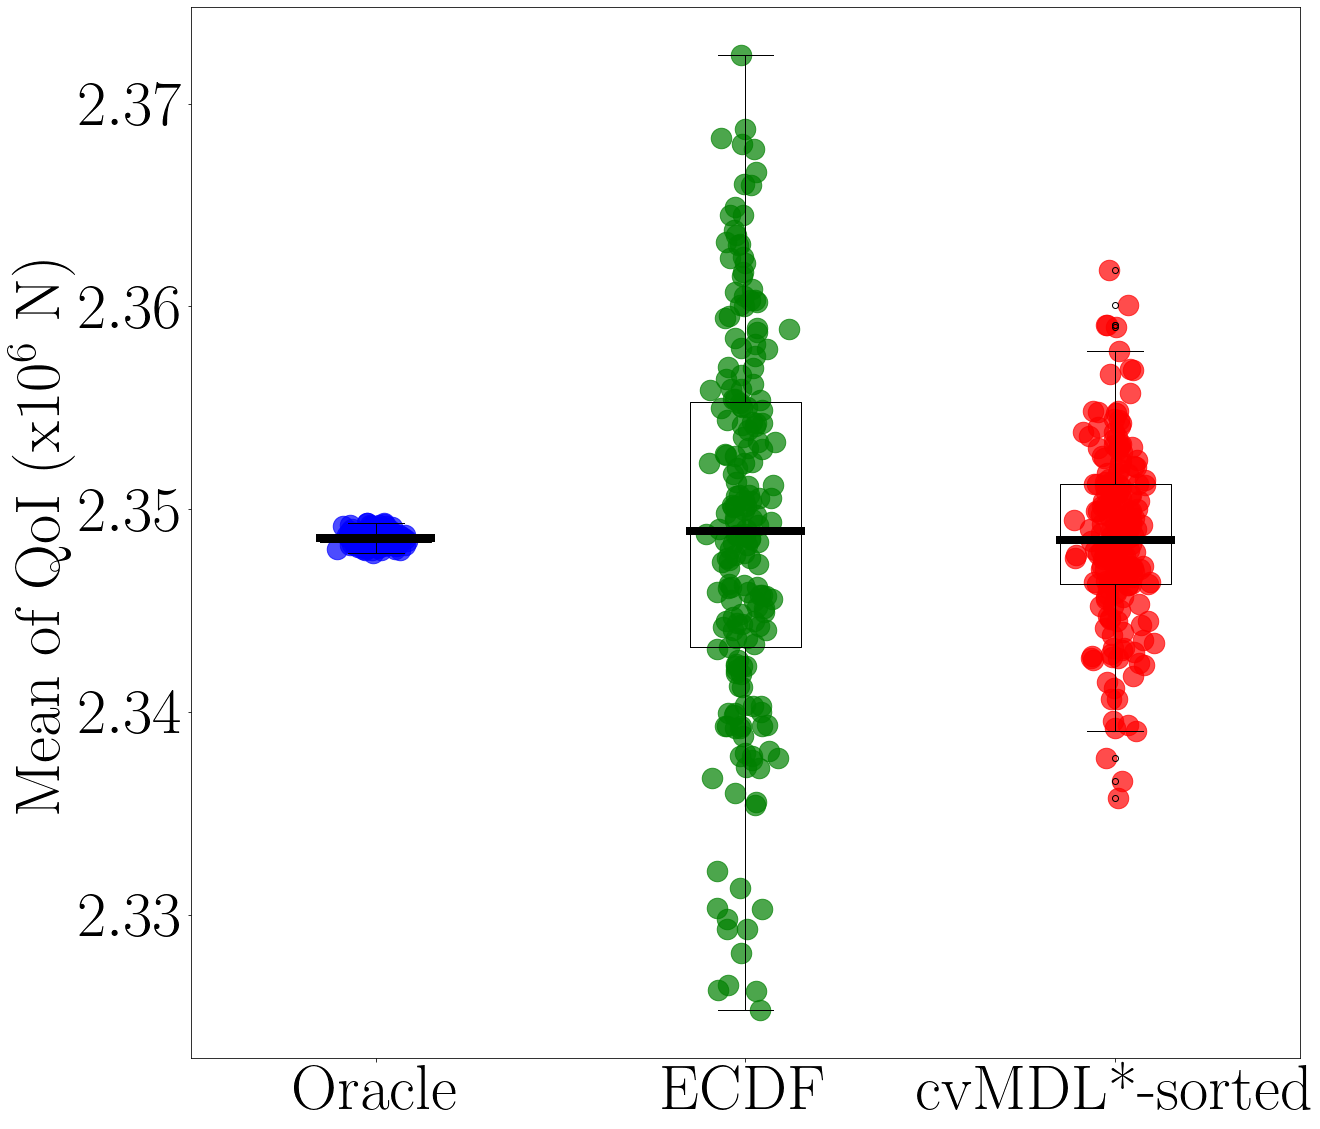

In [29]:
if not os.path.exists(foldername):
    os.makedirs(foldername)
    
data = [oracle_mean, ecdf_mean, cvMDL_mean]
fig, ax = plt.subplots(figsize=(22, 10*(24/12)))
box = ax.boxplot(data, patch_artist=False, medianprops=dict(color='black', linewidth=2*4))
plt.xticks(size = 32*2.0)
plt.yticks(size = 32*2.0)
#ax.set_ylim(2.335,2.365)

# Enable LaTeX rendering
rc('text', usetex=True)
# Set the desired font family
rc('font', family='serif')

ax.set_ylabel('Mean of QoI (x$10^6$ N)', fontsize=32*2.0) # Add y-axis label
# Adding x-tick labels
xticklabels = ['Oracle', 'ECDF', 'cvMDL*-sorted']
yticklabels = ['Oracle', 'ECDF', 'cvMDL*-sorted']
ax.set_xticklabels(xticklabels)
colors = ['blue', 'green', 'red']
for i, datat in enumerate(data):
    x = np.random.normal(i + 1, 0.04, size=len(datat))
    ax.scatter(x, datat, color = colors[i], alpha=0.7, s = 420)
plt.subplots_adjust(left=0.2, bottom=0.15)
plt.savefig(f"./{foldername}/brittle_mean.pdf", dpi=600)

## Boxplot of variance

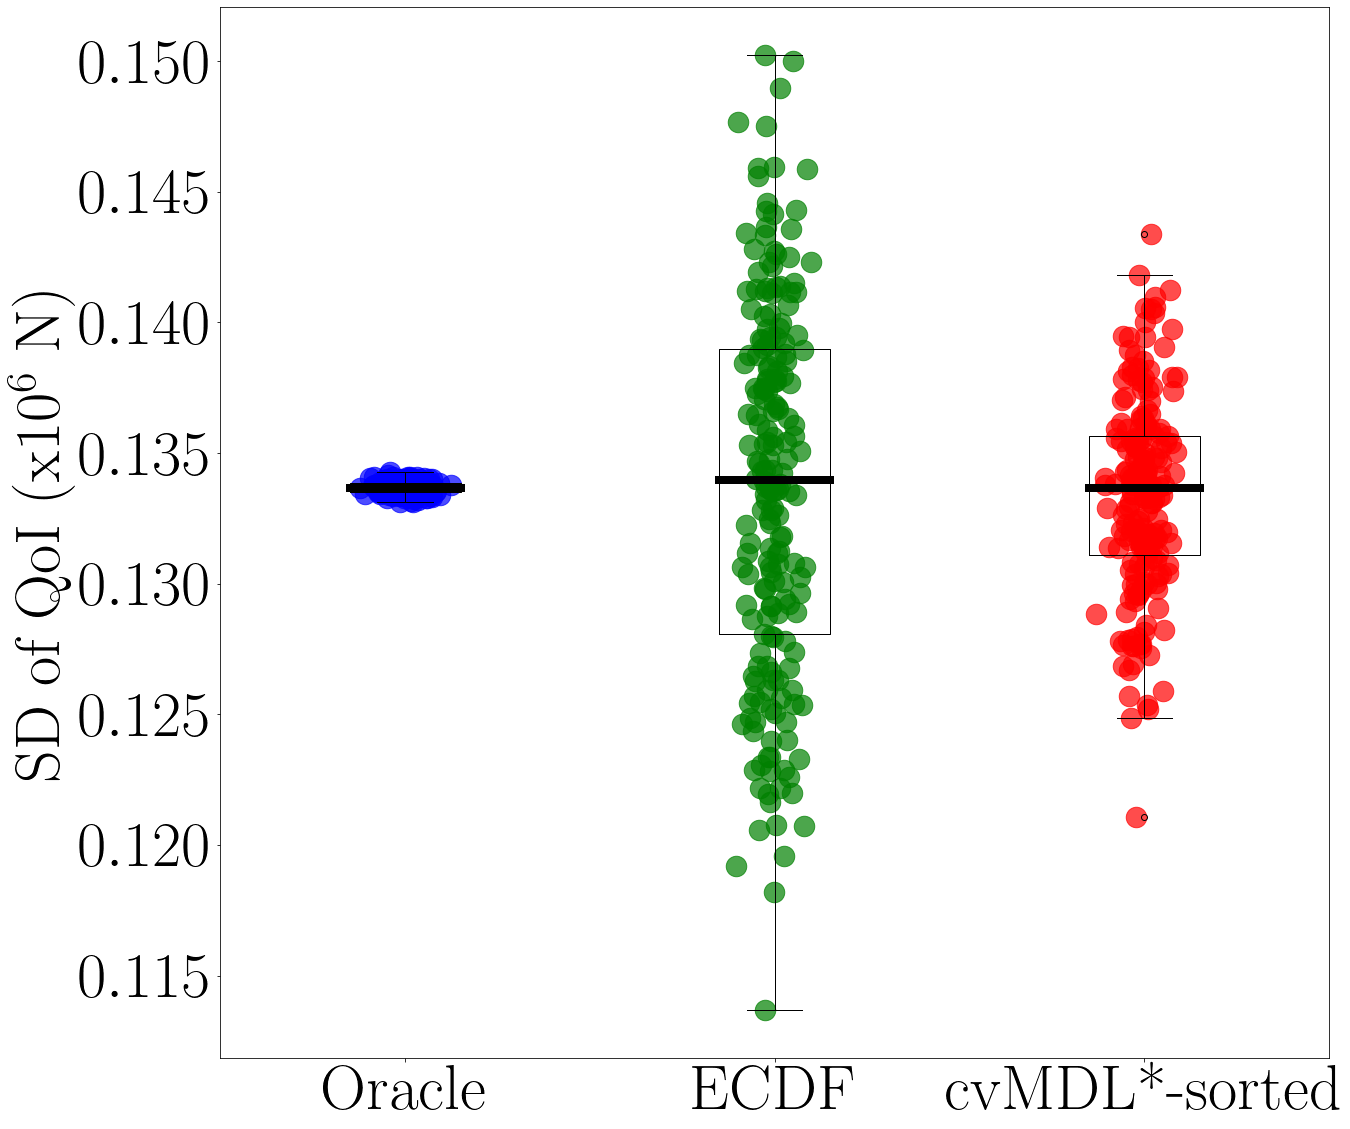

In [31]:
data = [np.array(oracle_sd), np.array(ecdf_sd), np.array(cvMDL_sd)]
fig, ax = plt.subplots(figsize=(22, 10*(24/12)))
box = ax.boxplot(data, patch_artist=False, medianprops=dict(color='black', linewidth=2*4))
plt.xticks(size = 32*2.0)
plt.yticks(size = 32*2.0)
#ax.set_ylim(0.014,0.021)

#eng_formatter = EngFormatter(places=1)  # You can modify the number of decimal places with the places argument
#ax.yaxis.set_major_formatter(eng_formatter)

ax.set_ylabel('SD of QoI (x$10^6$ N)', fontsize=32*2.0) # Add y-axis label
# Adding x-tick labels
xticklabels = ['Oracle', 'ECDF', 'cvMDL*-sorted']
yticklabels = ['Oracle', 'ECDF', 'cvMDL*-sorted']
ax.set_xticklabels(xticklabels)
colors = ['blue', 'green', 'red']
for i, datat in enumerate(data):
    x = np.random.normal(i + 1, 0.04, size=len(datat))
    ax.scatter(x, datat, color = colors[i], alpha=0.7, s = 420)
plt.subplots_adjust(left=0.2, bottom=0.15)
plt.savefig(f"./{foldername}/brittle_sd.pdf", dpi=600)